# Project Part 1 - Common Analysis
In this Notebook, we will answer the following common analysis question for Green Bay, Wisconsin:

- What are the estimated wildfire smoke impacts on Green Bay, Wisconsin each year for the most recent 60 years of wildfire data?

We start by extracting wildfire data from the [combined wildland fire dataset provided by USGS](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81) for the last 60 years. We then calculate the distance of each fire from our city of interest, Green Bay, and then create a smoke estimate based off each fire's distance to the city and size in acres for fires within 650 miles of the city. We use this estimate to fit a predictive model to predict smoke estimates for 2025-2050. We perform some basic exploratory analysis of the wildfire data to gain a better understanding of fire size and distance, and compare the smoke estimates with available Air Quality Index (AQI) data. The AQI data is sourced from the [US EPA Air Quality System (AQS) API](https://aqs.epa.gov/aqsweb/documents/data_api.html).

### License
Sample code for [extracting wildfire geojson data and calculating distances](https://drive.google.com/file/d/1B7AGlaW7d-27bHKLVXGBwLt8T-Elx-HB/view?usp=drive_link) (Revision 1.1 - August 16, 2024) and [acquiring the AQI API data](https://drive.google.com/file/d/1fwS60QStiMDqwINvW2LEDFBX5xg6Wnmg/view?usp=drive_link) (Revision 1.2 - August 16, 2024) were developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/) license. 

This notebook is available under the MIT license.

Start by importing necessary Python modules.

The 'wildfire' module is a user module created by Dr. David W. McDonald for student use in solving the DATA 512 class project.

In [1]:
import os, json, time
from pyproj import Transformer, Geod
# The 'wildfire' module is a user module. This module is available from the course website.
from wildfire.Reader import Reader as WFReader
import geojson, requests
from dotenv import load_dotenv #used for API key
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm

### Data
We start by extracting the GeoJSON data from the [combined wildland fire dataset provided by USGS](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81). The following code is adapted from [example code](https://drive.google.com/file/d/1B7AGlaW7d-27bHKLVXGBwLt8T-Elx-HB/view?usp=drive_link) developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. (Revision 1.1 - August 16, 2024)

We keep a dictionary of cities of interest for analysis - in this case, we only have Green Bay, Wisconsin.
The fips value is sourced from [here](https://www2.census.gov/geo/docs/reference/codes2020/cou/st55_wi_cou2020.txt) and combines the StateFP and CountyFP values.

In [2]:
EXTRACT_FILENAME = "Data/USGS_Wildland_Fire_Combined_Dataset.json"
#
#    The user module 'wildfire' contains a Reader object and the sample data. This bit of code finds where that is
#    located on your machine and constructs a path so that the sample data can be loaded. This assumes you have set
#    a PYTHONPATH environment variable to point to the location on your machine where you store python user modules.
#
#    NOTE: if you use Anaconda for virtual python environments, Anaconda will adhere to the PYTHONPATH conventions
#    for user modules.
#
MODULENAME = "wildfire"
MODULEPATH = ""
#
# print out where we think we're going to find the sample data
print(f"{EXTRACT_FILENAME=}")

#
#    A dictionary of our city of interest
#
CITY_LOCATIONS = {
    'green_bay' :     {'city'   : 'Green Bay',
                       'latlon' : [44.52, -87.99],
                       'county' : 'Brown',
                       'state'  : 'Wisconsin',
                       'fips'   : '55009',}
}

EXTRACT_FILENAME='Data/USGS_Wildland_Fire_Combined_Dataset.json'


In [3]:
#
#    This bit of code opens a new wildfire reader, gets the header information and prints it to the screen
#
print(f"Attempting to open '{EXTRACT_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(EXTRACT_FILENAME)
print()
#
#    Now print the header - it contains some useful information
#
header_dict = wfreader.header()
header_keys = list(header_dict.keys())
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))


Attempting to open 'Data/USGS_Wildland_Fire_Combined_Dataset.json' with wildfire.Reader() object


Header Dictionary
{
    "displayFieldName": "",
    "fieldAliases": {
        "OBJECTID": "OBJECTID",
        "USGS_Assigned_ID": "USGS Assigned ID",
        "Assigned_Fire_Type": "Assigned Fire Type",
        "Fire_Year": "Fire Year",
        "Fire_Polygon_Tier": "Fire Polygon Tier",
        "Fire_Attribute_Tiers": "Fire Attribute Tiers",
        "GIS_Acres": "GIS_Acres",
        "GIS_Hectares": "GIS_Hectares",
        "Source_Datasets": "Source Datasets",
        "Listed_Fire_Types": "Listed Fire Types",
        "Listed_Fire_Names": "Listed Fire Names",
        "Listed_Fire_Codes": "Listed Fire Codes",
        "Listed_Fire_IDs": "Listed Fire IDs",
        "Listed_Fire_IRWIN_IDs": "Listed Fire IRWIN IDs",
        "Listed_Fire_Dates": "Listed Fire Dates",
        "Listed_Fire_Causes": "Listed Fire Causes",
        "Listed_Fire_Cause_Class": "Listed Fire Cause Class",
        "Listed_Rx_Re

Next, we load all the data from the file using the wildfire.Reader object. We store each feature in a list.

Print statements were adapted to prevent logging too much to memory and slowing down our operating system.
This section will take a bit to load.

In [5]:
#
#    This sample code will load the whole file
#
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 10000) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    feature = wfreader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")

Loaded 10000 features
Loaded 20000 features
Loaded 30000 features
Loaded 40000 features
Loaded 50000 features
Loaded 60000 features
Loaded 70000 features
Loaded 80000 features
Loaded 90000 features
Loaded 100000 features
Loaded 110000 features
Loaded 120000 features
Loaded 130000 features
Loaded a total of 135061 features
Variable 'feature_list' contains 135061 features


Next, we will calculate the distance each fire is from our city. We use the geometry data for each feature to determine this distance.

We define two formulas, one to calculate the shortest distance and one to calculate the average distance. The average distance is a proxy for the center of a fire.

For the following parts of the analysis, we will use the average distance as the primary definition of a fire's distance from the city.

We create the following function to transform feature geometry data to EPSG:4326 to facilitate distance calculations.

In [547]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        try:
            if len(coord) != 2:
                break
            lat,lon = to_epsg4326.transform(coord[0],coord[1])
            new_coord = lat,lon
            converted_ring.append(new_coord)
        except (IndexError, KeyError, TypeError, ZeroDivisionError) as e:
            print(f"Error {e}, skip")
    return converted_ring

In [19]:
#
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point



#
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    if len(distances_in_miles_no_dup) > 0: # denominator can be zero -> that means the ring is a point?
        average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    else:
        average = None # prevent erroring out... how else can i represent this case correctly??
    return average


Now we run each feature in our wildfire data through the distance calculation functions to get the average distance to Green Bay. We store these output in a list of dictionaries, where each dictionary has the fire year, fire size in acres, and the average distance. Note that this code takes a while to run.

In [22]:
place = CITY_LOCATIONS["green_bay"]
fire_distance_data = []
feature_count = 0

for wf_feature in feature_list:
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']
    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        raise Exception("HEY! No compatible geometry in this fire data!!!")

    #     Compute using the average distance to all points on the perimeter
    #
    avg_distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    ring = convert_ring_to_epsg4326(ring_data)
    perimeter_start = ring[0]
    fire_distance_data.append({
        "Fire_Year": wf_year,
        "Fire_Size_Acres": wf_size,
        "Average Distance to City": avg_distance
    })
    feature_count += 1
    if (feature_count % 10000) == 0:
        print(f"Calculated distance for {feature_count} features")

Calculated distance for 10000 features
Calculated distance for 20000 features
Calculated distance for 30000 features
Calculated distance for 40000 features
Calculated distance for 50000 features
Calculated distance for 60000 features
Calculated distance for 70000 features
Calculated distance for 80000 features
Calculated distance for 90000 features
Calculated distance for 100000 features
Calculated distance for 110000 features
Calculated distance for 120000 features
Calculated distance for 130000 features


We store this intermediate dataset in a CSV file for future reference and to prevent having to run the above code multiple times.

In [ ]:
fire_distance_data_df = pd.DataFrame(fire_distance_data)

In [29]:
fire_distance_data_df.head()

,Fire_Year,Fire_Size_Acres,Average Distance to City
0,1860,3940.207089,1684.004436
1,1860,772.518249,1683.988870
2,1860,333.020409,1685.096404
3,1870,22294.993577,1350.607282
4,1870,36.985574,1300.402668


In [30]:
fire_distance_data_df.to_csv('fire_distance_data.csv')

For the sake of the analysis, we take create a subset containing the last 60 years of data (1964-2024). 

We see that the latest year in the wildfire data is 2020. For the sake of not including years more than 60 years back, we will keep the start of the time period to be 1964 and acknowledge that we are missing 4 years of wildfire data. As such, the subsequent smoke estimate and other analyses on the wildfire data will also end at 2020.

In [2]:
# filter to just last 60 years
fire_distance_data_df = pd.read_csv('intermediate_data/fire_distance_data.csv')
fire_data = fire_distance_data_df[fire_distance_data_df['Fire_Year'] >= 1964]
fire_data['Fire_Year'].max()

2020

In [145]:
fire_data.head()

,Fire_Year,Fire_Size_Acres,Average Distance to City
14599,1964,65338.877636,1813.095833
14600,1964,55960.694158,1826.886832
14601,1964,19218.105903,1714.004680
14602,1964,18712.494746,1790.375354
14603,1964,16887.001024,1863.460538


Next, we retrieve Air Quality Index data from the Air Quality Index (AQI) API. The following code is adapted from [this example code](https://drive.google.com/file/d/1fwS60QStiMDqwINvW2LEDFBX5xg6Wnmg/view?usp=drive_link) developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. (Revision 1.2 - August 16, 2024)

In [34]:
##### API part
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
#
AQS_REQUEST_TEMPLATE = {
    "email":      "",
    "key":        "",
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



In [35]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL,
                   endpoint_action = API_ACTION_SIGNUP,
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):

    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address

    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']:
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




We run the API signup request below. The following code is commented out to prevent running it more than once. Username should be your email. After running the following block, an email with the key will be sent to the email. Store this in a .env file for the following code.

In [36]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
# print("Requesting SIGNUP ...")
# USERNAME = "ezhang33@uw.edu"
# response = request_signup(USERNAME)
# print(json.dumps(response,indent=4))
#

We use the dotenv package to load our credentials from our .env file. We use a .env file to prevent key leakage when sharing code.

In [42]:
#
#   Once we have the signup email, we can define two constants:
#
#   USERNAME - This should be the email address you sent the EPA asking for access to the API during sign-up
#   APIKEY   - This should be the authorization key they sent you
#
#
#   Naturally, you should probably use the USERNAME that you used when you requested the API Key. I've used my email
#   address as my USERNAME when I added the API Key to the Key manager. This will look it up for me.
load_dotenv()
USERNAME = "ezhang33@uw.edu"
APIKEY = os.getenv('EPA_API_KEY')

The following function is used to get the sensor IDs for the AQI pollutants we're interested in, as well as a list of monitoring stations for our city of interest.

In [43]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL,
                      endpoint_action = API_ACTION_LIST_CLASSES,
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):

    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key

    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [44]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

In [45]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [46]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


In [47]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#
#

In [50]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['green_bay']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['green_bay']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": "GREEN BAY EAST HIGH"
    },
    {
        "code": "0006",
        "value_represented": null
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": null
    },
    {
        "code": "0009",
        "value_represented": null
    },
    {
        "code": "0010",
        "value_represented": null
    },
    {
        "code": "0011",
        "value_represented": null
    },
    {
        "code": "0012",
        "value_represented": null
    },
    {
        "code": "0013",
        "value_represented": null
    },
    {
        "code": "0014",
        "value_represented":

The below function is used to request daily AQI summaries from the API for each sensor for a given time range. 

In [37]:

#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date.
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL,
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY,
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):

    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']:
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']:
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']:
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



We loop through each year from 1964 to 2024 and only request data for the fire season (May 1st through October 31st). We request gaseous and particulate data separately due to API constraints (mentioned in an above block where we split the codes into the two lists). After retrieving data for both types, we combine the two into one dataframe and take the average for each year.

It can be noted that AQI data for Green Bay, WI is not available until 1985 due to the EPA beginning its installation of air quality stations in the 1980s. As such, the sparsity of this data is to be expected.

In [68]:
# request daily summary data for fire seasons starting from 1961 to now

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['green_bay']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['green_bay']['fips'][2:]

gaseous_aqi_data = []
particulate_aqi_data = []

for year in list(range(1964,2025)):
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=f"{year}0701", end_date=f"{year}1031")
    if gaseous_aqi["Header"][0]['status'] == "Success":
        for item in gaseous_aqi['Data']:
            filtered_item = {
                    "date_local": item.get("date_local"),
                    "aqi": item.get("aqi"),
                }
            gaseous_aqi_data.append(filtered_item)
    elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
        print(f"Looks like the response generated no data for {year}. You might take a closer look at your request and the response data.")
    else:
        for item in gaseous_aqi:
            filtered_item = {
                    "date_local": item.get("date_local"),
                    "aqi": item.get("aqi"),
                }
            gaseous_aqi_data.append(filtered_item)

    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=f"{year}0701", end_date=f"{year}1031")
    if particulate_aqi["Header"][0]['status'] == "Success":
        for item in particulate_aqi['Data']:
            filtered_item = {
                    "date_local": item.get("date_local"),
                    "aqi": item.get("aqi"),
                }
            particulate_aqi_data.append(filtered_item)
    elif particulate_aqi["Header"][0]['status'].startswith("No data "):
        print(f"Looks like the response generated no data for {year}. You might take a closer look at your request and the response data.")
    else:
        for item in particulate_aqi:
            filtered_item = {
                    "date_local": item.get("date_local"),
                    "aqi": item.get("aqi"),
                }
            particulate_aqi_data.append(filtered_item)

gaseous_aqi_df = pd.DataFrame(gaseous_aqi_data)
particulate_aqi_df = pd.DataFrame(particulate_aqi_data)


Looks like the response generated no data for 1961. You might take a closer look at your request and the response data.
Looks like the response generated no data for 1961. You might take a closer look at your request and the response data.
Looks like the response generated no data for 1962. You might take a closer look at your request and the response data.
Looks like the response generated no data for 1962. You might take a closer look at your request and the response data.
Looks like the response generated no data for 1963. You might take a closer look at your request and the response data.
Looks like the response generated no data for 1963. You might take a closer look at your request and the response data.
Looks like the response generated no data for 1964. You might take a closer look at your request and the response data.
Looks like the response generated no data for 1964. You might take a closer look at your request and the response data.
Looks like the response generated no dat

In [75]:
gaseous_aqi_df = pd.DataFrame(gaseous_aqi_data)
particulate_aqi_df = pd.DataFrame(particulate_aqi_data)

# convert the year column into dates
particulate_aqi_df['year'] = pd.to_datetime(particulate_aqi_df['date_local']).dt.year
gaseous_aqi_df['year'] = pd.to_datetime(gaseous_aqi_df['date_local']).dt.year

In [77]:
# drop any null values
gaseous_aqi_df_clean = gaseous_aqi_df.dropna()
particulate_aqi_df_clean = particulate_aqi_df.dropna()

In [82]:
# group by year, combine, and take the mean
gaseous_aqi_agg = gaseous_aqi_df_clean.groupby('year', as_index = False).agg({'aqi': 'mean'})
particulate_aqi_agg = particulate_aqi_df_clean.groupby('year', as_index = False).agg({'aqi': 'mean'})
aqi_estimates = pd.concat([gaseous_aqi_agg,particulate_aqi_agg]).groupby('year', as_index = False).agg({'aqi': 'mean'})

In [89]:
aqi_estimates

,year,aqi
0,1985,32.043478
1,1986,28.450000
2,1987,27.400000
3,1988,24.129310
4,1989,29.928571
5,1990,25.653061
6,1991,22.775000
7,1992,16.400000
8,1993,24.384615
9,1999,44.385965


We save this intermediate dataset to a CSV file for future reference.

In [548]:
aqi_estimates.to_csv('aqi_estimates.csv')

### Smoke Estimate

Here we will create a smoke estimate metric and fit a predictive model to predict smoke estimates for 2025-2050.

Due to the complex nature of wildfire smoke and the limitations with data and time, we simplify our smoke estimates to be a function of fire size and distance only. 

The smoke estimate follows the following conditions:
- The estimate only considers the last 60 years of wildland fire data (1964-2024)
- The estimate only considers fires that are within 650 miles of Green Bay, WI
- The annual fire season is defined as running from May 1st through October 31st

We start by filtering the wildfires to those within 650 miles of Green Bay, WI.

We then convert fire sizes from acres to square miles to align units. Though the estimate does not have a particular unit associated with it, this conversion allows for easier comparisons between the factors.

In [3]:
# load in the data from the intermediate csv
fire_data = pd.read_csv('intermediate_data/fire_distance_data.csv')
fire_data = fire_data[fire_data['Fire_Year'] >= 1964]
fire_data.head()

,Unnamed: 0,Fire_Year,Fire_Size_Acres,Average Distance to City
14599,14599,1964,65338.877636,1813.095833
14600,14600,1964,55960.694158,1826.886832
14601,14601,1964,19218.105903,1714.004680
14602,14602,1964,18712.494746,1790.375354
14603,14603,1964,16887.001024,1863.460538


In [4]:
fire_near_city = fire_data.loc[fire_data["Average Distance to City"] <= 650, ["Fire_Year", "Fire_Size_Acres", "Average Distance to City"]].copy()
fire_near_city.loc[:,"Fire_Size_Sq_Miles"] = fire_near_city["Fire_Size_Acres"] / 640
fire_near_city.loc[:,"Sq_Distance"] = fire_near_city["Average Distance to City"]**2
fire_near_city.head()

,Fire_Year,Fire_Size_Acres,Average Distance to City,Fire_Size_Sq_Miles,Sq_Distance
14738,1964,152.453318,309.891628,0.238208,96032.821144
14810,1964,6.066192,645.331497,0.009478,416452.740900
14881,1964,0.069102,649.583125,0.000108,421958.235644
14889,1965,18675.433939,645.899635,29.180366,417186.337931
15036,1965,3.978242,646.333026,0.006216,417746.379959


Our smoke estimate is defined below:
$$ scaling factor * \frac{fire size}{{fire distance}^2}$$

We use the [inverse-square law](https://en.wikipedia.org/wiki/Inverse-square_law) as the basis of our definition, where the severity of smoke is inversely proportional to the distance from the center of the fire.

We then scale the estimate by to bring it to a more comparable number. The scaling factor is simply an arbitrary number that brings the estimates to a scale comparable with AQI estimates. This estimate is calculated for each estimate and then aggregated to get a yearly estimate.

In this intial definition, we use the mean of estimates for the year.

In [5]:
smoke_estimate_intermediate = fire_near_city.copy()
scaling_factor = 2000000
# calculate estimate for each fire
smoke_estimate_intermediate['Smoke_Estimate'] = scaling_factor*(smoke_estimate_intermediate['Fire_Size_Sq_Miles'])/(smoke_estimate_intermediate['Sq_Distance'])
smoke_estimate = smoke_estimate_intermediate.copy()

# aggregate and take mean for the year
smoke_estimate = smoke_estimate.groupby('Fire_Year', as_index = False).agg({'Smoke_Estimate':'mean'})
smoke_estimate.head()

,Fire_Year,Smoke_Estimate
0,1964,0.313976
1,1965,6.712423
2,1966,0.081187
3,1967,1.447034
4,1968,0.120033


<Figure size 1000x600 with 0 Axes>

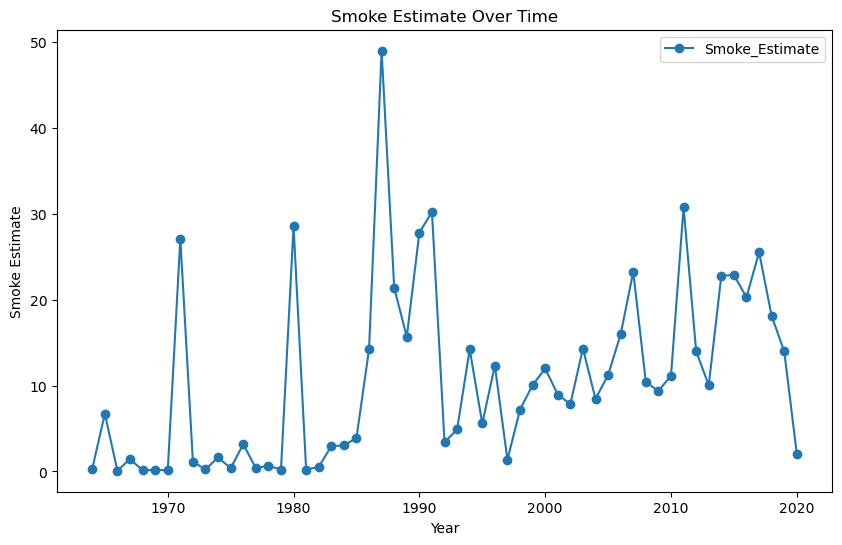

In [6]:
plt.figure(figsize=(10, 6))
smoke_estimate.plot(x='Fire_Year', y='Smoke_Estimate', kind='line', marker='o', title='Smoke Estimate Over Time', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.show()

While creating this graph, we took a look at the total acres burned per year within 650 miles of the city (refer to the graph in the Visualizations section). Comparing that graph to the above graph posed the following question - would a year with one large fire moderately far away contribute more smoke to the annual estimate than multiple smaller, similarly-sized fires that are close? By taking the average of all the smoke estimates without any weight on frequency, this estimate is not the most representative.

As such, we make the following adjustment to reflect fire frequency in a year. We take the smoke estimates for each fire in a year and first sum them, then divide all yearly estimates by the number of days in the fire season. Fire season is defined as running from May 1st to October 31st inclusive, 184 days total. We keep all other factors the same as the previous definition.

The scaling factor here is adjusted to keep the estimates in a similar range to AQI data.

In [10]:
# building on the previous, we instead aggregate over the year and then divide by the number of days in the fire season
smoke_estimate_intermediate = fire_near_city.copy()
scaling_factor = 1000000
# calculate estimate for each fire
smoke_estimate_intermediate['Smoke_Estimate'] = scaling_factor*(smoke_estimate_intermediate['Fire_Size_Sq_Miles'])/(smoke_estimate_intermediate['Sq_Distance'])
smoke_estimate = smoke_estimate_intermediate.copy()

# aggregate and average over the fire season
smoke_estimate = smoke_estimate.groupby('Fire_Year', as_index = False).agg({'Smoke_Estimate':'sum'}).rename(columns = {'Smoke_Estimate':'Agg_Smoke_Estimate'})
smoke_estimate['Smoke_Estimate'] = smoke_estimate['Agg_Smoke_Estimate']/184
smoke_estimate.head()

,Fire_Year,Agg_Smoke_Estimate,Smoke_Estimate
0,1964,3.767711,0.020477
1,1965,70.480446,0.383046
2,1966,0.811870,0.004412
3,1967,20.258481,0.110100
4,1968,1.740473,0.009459


<Figure size 1000x600 with 0 Axes>

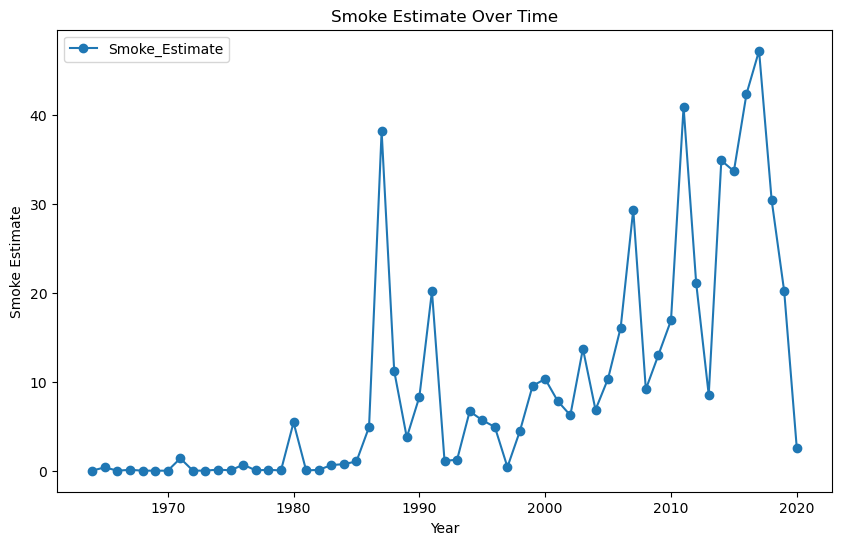

In [11]:
plt.figure(figsize=(10, 6))
smoke_estimate.plot(x='Fire_Year', y='Smoke_Estimate', kind='line', marker='o', title='Smoke Estimate Over Time', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.show()

Next, we use the estimates for the past 60 years to predict values for the next 25 years (2025-2050). 

Our model will use year as the independent variable and smoke estimate as the dependent variable.

We start by fitting a simple linear model. Our reasoning behind this is that although the smoke estimate trend looks quite complex, it has a generally upwards trend, especially in recent years. We thought it would be worth a shot to try and capture the general trend using a simple linear model.

                            OLS Regression Results                            
Dep. Variable:         Smoke_Estimate   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     49.07
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           3.70e-09
Time:                        00:03:21   Log-Likelihood:                -207.28
No. Observations:                  57   AIC:                             418.6
Df Residuals:                      55   BIC:                             422.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1040.6584    149.952     -6.940      0.0

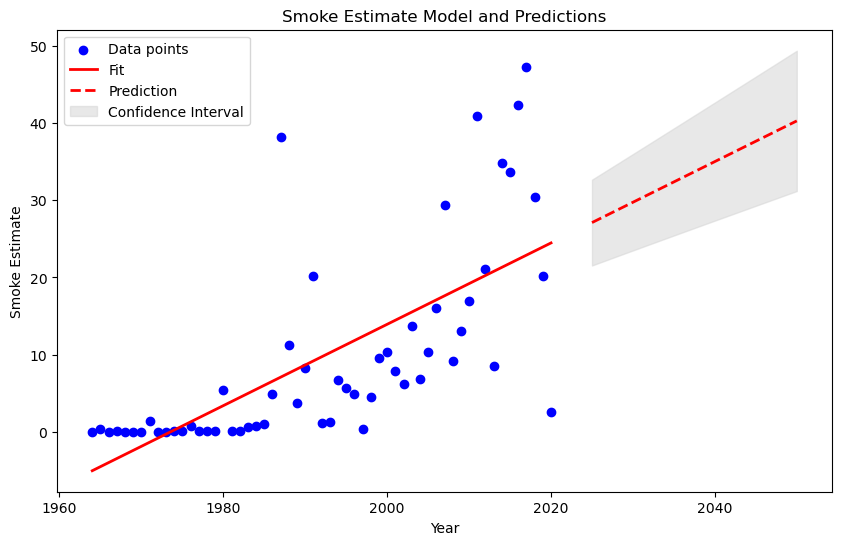

In [12]:
# we try fitting a simple linear model first
x = smoke_estimate['Fire_Year']
y = smoke_estimate['Smoke_Estimate']
degree = 1

# fit model
X = np.column_stack([x**i for i in range(degree + 1)])
smoke_model = sm.OLS(y, X).fit()
print(smoke_model.summary())
x_fit = np.column_stack([x**i for i in range(degree + 1)])
y_fit = smoke_model.predict(x_fit)

# predict 2025-2050 and get prediction intervals
x_prediction = np.arange(2025, 2051, 1)
X_prediction = np.column_stack([x_prediction**i for i in range(degree + 1)])
y_prediction = smoke_model.predict(X_prediction)

conf_predictions = smoke_model.get_prediction(X_prediction)
conf_int = conf_predictions.conf_int()

predictions = pd.DataFrame({
    'Year': x_prediction,
    'Smoke_Estimate': y_prediction
})

# plot the data and the predictions
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_fit, color='red', label='Fit', linewidth=2)
plt.plot(x_prediction, y_prediction, color='red', linestyle='--', label='Prediction', linewidth=2)
plt.fill_between(x_prediction, conf_int[:, 0], conf_int[:, 1], color='lightgray', alpha=0.5, label='Confidence Interval')


plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('Smoke Estimate Model and Predictions')
plt.legend()
plt.show()

In [13]:
conf_int_df = pd.DataFrame(conf_int, columns=['lower_bound', 'upper_bound'])
predictions = pd.concat([predictions.copy(), conf_int_df], axis = 1)
predictions

,Year,Smoke_Estimate,lower_bound,upper_bound
0,2025,27.111034,21.548521,32.673548
1,2026,27.638328,21.940411,33.336244
2,2027,28.165621,22.331543,33.999700
3,2028,28.692915,22.721969,34.663861
4,2029,29.220208,23.111736,35.328681
5,2030,29.747502,23.500888,35.994116
6,2031,30.274795,23.889464,36.660127
7,2032,30.802089,24.277502,37.326676
8,2033,31.329383,24.665035,37.993731
9,2034,31.856676,25.052094,38.661259


We notice that the point for 1987 is much higher than the surrounding years. This point could be an influential point that is detracting from model accuracy. As such, we try the model without the outlier below. Instead of removing it entirely, we replace it with the average smoke estimate of the previous and subsequent years.

                            OLS Regression Results                            
Dep. Variable:         Smoke_Estimate   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     56.79
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           4.99e-10
Time:                        00:03:27   Log-Likelihood:                -202.53
No. Observations:                  57   AIC:                             409.1
Df Residuals:                      55   BIC:                             413.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1030.5242    137.970     -7.469      0.0

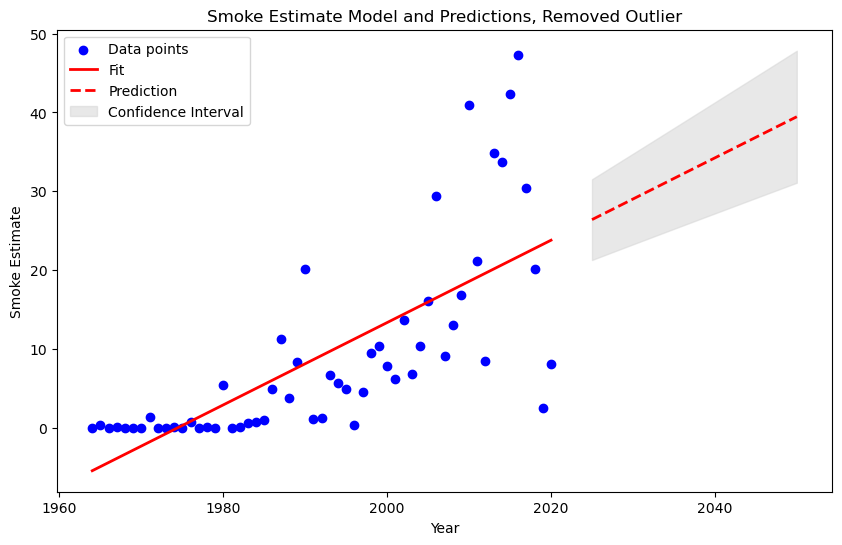

In [14]:
#let's try removing the outlier
outlier = 1987
smoke_estimate_clean = smoke_estimate[~(smoke_estimate['Fire_Year']==outlier)].copy()
dummy_estimate = (smoke_estimate[smoke_estimate['Fire_Year']==outlier-1].values[0][2]+smoke_estimate[smoke_estimate['Fire_Year']==outlier+1].values[0][2])/2
new_row = pd.DataFrame({'Fire_Year': [outlier], 'Smoke_Estimate': [dummy_estimate]})
smoke_estimate_clean = pd.concat([smoke_estimate_clean, new_row], ignore_index=True)

x = smoke_estimate_clean['Fire_Year'].sort_values()
y = smoke_estimate_clean['Smoke_Estimate']
degree = 1

# fit model
X = np.column_stack([x**i for i in range(degree + 1)])
smoke_model_clean = sm.OLS(y, X).fit()
print(smoke_model_clean.summary())
x_fit = np.column_stack([x**i for i in range(degree + 1)])
y_fit = smoke_model_clean.predict(x_fit)

# predict 2025-2050 and get prediction intervals
x_prediction = np.arange(2025, 2051, 1)
X_prediction = np.column_stack([x_prediction**i for i in range(degree + 1)])
y_prediction = smoke_model_clean.predict(X_prediction)

conf_predictions = smoke_model_clean.get_prediction(X_prediction)
conf_int = conf_predictions.conf_int()

predictions = pd.DataFrame({
    'Year': x_prediction,
    'Smoke_Estimate': y_prediction
})

# plot the data and the predictions
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_fit, color='red', label='Fit', linewidth=2)
plt.plot(x_prediction, y_prediction, color='red', linestyle='--', label='Prediction', linewidth=2)
plt.fill_between(x_prediction, conf_int[:, 0], conf_int[:, 1], color='lightgray', alpha=0.5, label='Confidence Interval')


plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('Smoke Estimate Model and Predictions, Removed Outlier')
plt.legend()
plt.show()

In [16]:
conf_int_df = pd.DataFrame(conf_int, columns=['lower_bound', 'upper_bound'])
predictions = pd.concat([predictions.copy(), conf_int_df], axis = 1)
print(predictions)

    Year  Smoke_Estimate  lower_bound  upper_bound  lower_bound  upper_bound
0   2025       26.405882    21.287853    31.523910    21.287853    31.523910
1   2026       26.927822    21.685211    32.170434    21.685211    32.170434
2   2027       27.449763    22.081870    32.817656    22.081870    32.817656
3   2028       27.971704    22.477880    33.465528    22.477880    33.465528
4   2029       28.493645    22.873283    34.114006    22.873283    34.114006
5   2030       29.015586    23.268121    34.763050    23.268121    34.763050
6   2031       29.537526    23.662429    35.412624    23.662429    35.412624
7   2032       30.059467    24.056242    36.062693    24.056242    36.062693
8   2033       30.581408    24.449590    36.713226    24.449590    36.713226
9   2034       31.103349    24.842502    37.364196    24.842502    37.364196
10  2035       31.625289    25.235004    38.015575    25.235004    38.015575
11  2036       32.147230    25.627122    38.667339    25.627122    38.667339

With the results of the linear regressions above, we can see that a simple linear model is not the best fit. We will try an ARIMA model below. We use the cleaned data (with removal of the outlier) and fill in missing years for the sake of using a time-series model. We then check for stationarity and the best parameters to use in fitting the ARIMA model. 

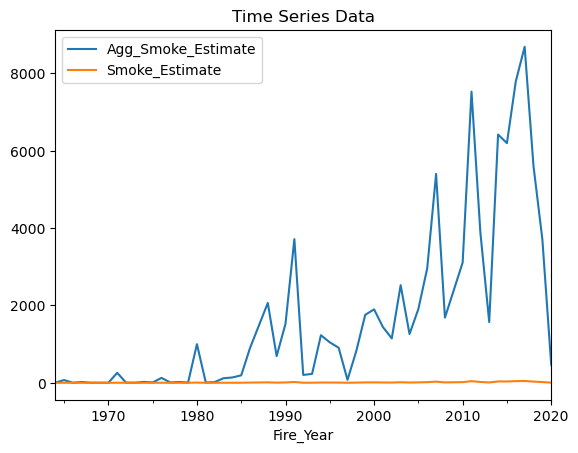

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Fill in missing years
smoke_estimate_arima = smoke_estimate_clean.sort_values(by='Fire_Year').copy()
smoke_estimate_arima['Fire_Year'] = pd.to_datetime(smoke_estimate_arima['Fire_Year'], format='%Y')
smoke_estimate_arima = smoke_estimate_arima.interpolate(method='linear')
smoke_estimate_arima.set_index('Fire_Year', inplace=True)

# Plotting the data
smoke_estimate_arima.plot()
plt.title("Time Series Data")
plt.show()

In [18]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(smoke_estimate_arima['Smoke_Estimate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.8293406544565807
p-value: 0.054203346867152856


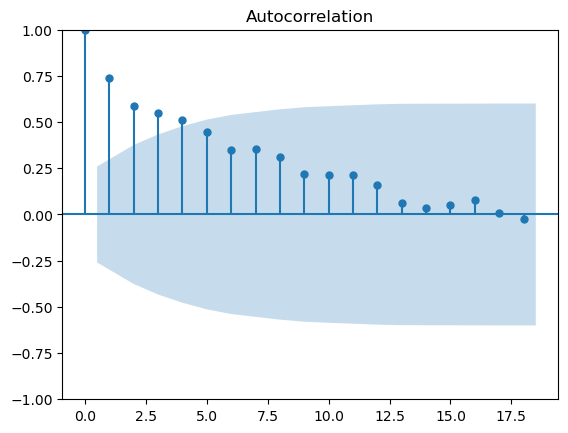

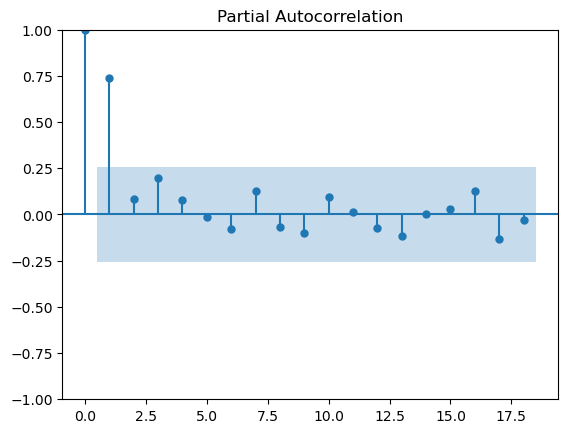

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=404.274, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=404.310, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=400.697, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=402.276, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=399.310, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=397.795, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=402.320, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=398.548, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=398.735, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=396.736, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=398.735, Time=0.02 se

In [19]:
# Plot ACF and PACF to determine order of AR/MA terms

plot_acf(smoke_estimate_arima['Smoke_Estimate'])
plot_pacf(smoke_estimate_arima['Smoke_Estimate'])
plt.show()

# Use Auto-ARIMA to find the best (p, d, q) parameters
from pmdarima import auto_arima

auto_model = auto_arima(smoke_estimate_arima['Smoke_Estimate'], seasonal=False, trace=True)
print(auto_model.summary())

Here, we fit the ARIMA model using p, d, and q values of 0, 1, and 2, respectively. We then check the model fit with the historical data and calculate predictions for 2025-2050 and plot with confidence invervals.

In [20]:
# Define the ARIMA model
p = 0  # Order of the autoregressive term
d = 1  # Number of differencing needed to make the series stationary
q = 2  # Order of the moving average term

model = ARIMA(smoke_estimate_arima['Smoke_Estimate'], order=(p, d, q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         Smoke_Estimate   No. Observations:                   57
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -195.368
Date:                Thu, 21 Nov 2024   AIC                            396.736
Time:                        00:04:00   BIC                            402.812
Sample:                    01-01-1964   HQIC                           399.092
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3722      0.123     -3.019      0.003      -0.614      -0.131
ma.L2         -0.3044      0.119     -2.561      0.010      -0.537      -0.071
sigma2        62.1826      7.937      7.835      0.0

/home/ezhang33/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/ezhang33/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/ezhang33/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


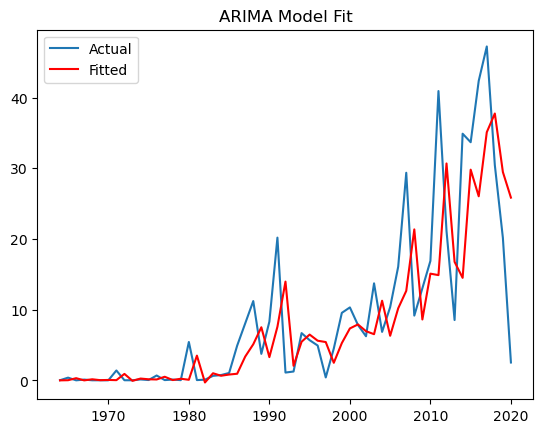

In [21]:
# Plot the actual data versus the fitted values
plt.plot(smoke_estimate_arima.index, smoke_estimate_arima['Smoke_Estimate'], label='Actual')
plt.plot(smoke_estimate_arima.index, model_fit.fittedvalues, color='red', label='Fitted')
plt.title("ARIMA Model Fit")
plt.legend()
plt.show()

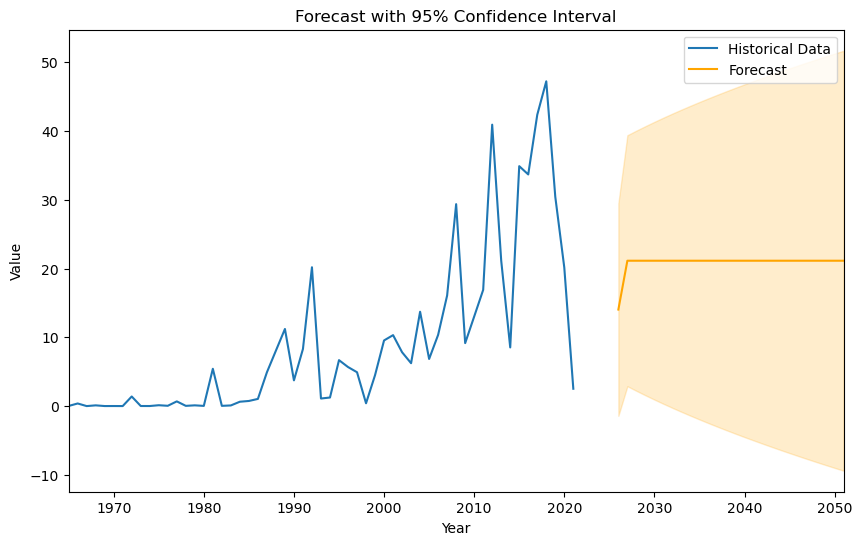

In [22]:
# Number of years to forecast
steps_ahead = 26

# Generate forecast
forecast = model_fit.get_forecast(steps=steps_ahead)

# Extract forecast values and confidence intervals
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create a range of years from 2025 onwards
forecast_years = pd.date_range(start='2025', periods=steps_ahead, freq='Y')

# Assign the forecast values and confidence intervals to a DataFrame
forecast_df = pd.DataFrame({
    'Year': forecast_years.year,
    'Forecast': forecast_values,
    'Lower CI': conf_int.iloc[:, 0],
    'Upper CI': conf_int.iloc[:, 1]
}).set_index('Year')

# Ensure both historical and forecasted data have the same frequency (yearly in this case)
historical_index = pd.date_range(start='1964', end='2021', freq='Y')
forecast_years = pd.date_range(start='2025', periods=26, freq='Y')

# Now ensure both DataFrames are using the same frequency
smoke_estimate_arima.index = historical_index
forecast_df.index = forecast_years

# Combine historical and forecasted data into one DataFrame
combined_data = pd.concat([
    smoke_estimate_arima['Smoke_Estimate'],  # Historical data
    forecast_df['Forecast']  # Forecast data
])

# Combine index of historical and forecast periods
combined_index = smoke_estimate_arima.index.append(forecast_df.index)

# Plot the combined data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(smoke_estimate_arima.index, smoke_estimate_arima['Smoke_Estimate'], label='Historical Data')

# Plot forecasted values
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='orange')

# Plot confidence intervals
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='orange', alpha=0.2)

# Set plot labels and title
plt.title('Forecast with 95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Value')

# Adjust x-axis limits to ensure all data is visible
plt.xlim([smoke_estimate_arima.index.min(), forecast_df.index.max()])

# Show legend
plt.legend()

# Display the plot
plt.show()



We see that the predictions result in a straight line, which does not seem to make much sense.

As such, we try fitting an exponential smoothing model below.

In [ ]:
# try exponential smoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.preprocessing import MinMaxScaler

# fill in missing years
smoke_estimate_ets = smoke_estimate_clean.sort_values(by='Fire_Year').copy()
smoke_estimate_ets['Fire_Year'] = pd.to_datetime(smoke_estimate_ets['Fire_Year'], format='%Y')
smoke_estimate_ets = smoke_estimate_ets.interpolate(method='linear')
smoke_estimate_ets.set_index('Fire_Year', inplace=True)

# Transform data to keep within 0 and 1
data_adjusted = smoke_estimate_ets['Smoke_Estimate'] + 1e-6
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_adjusted.values.reshape(-1, 1))

# Fit Exponential Smoothing model
ets_model = ETSModel(
    endog=data_scaled.flatten(),
    trend='add',
    seasonal=None,
)
ets_result = ets_model.fit()

# Simulate predictions
forecast_years = np.arange(2025, 2051)
n_repetitions = 500

exp_simul = ets_result.simulate(
    nsimulations = 31,
    repetitions=n_repetitions,
    anchor='end'
)
exp_simul = pd.DataFrame(exp_simul, columns=[f'Simulation_{i}' for i in range(n_repetitions)])
mean_simulation = exp_simul.mean(axis=1)

# Calculate confidence intervals
upper_ci = exp_simul.quantile(q=0.975, axis='columns')
lower_ci = exp_simul.quantile(q=0.025, axis='columns')

# Reverse the reshaping performed earlier
forecast_original = scaler.inverse_transform(mean_simulation.values.reshape(-1, 1)).flatten()
upper_ci_ori = scaler.inverse_transform(upper_ci.values.reshape(-1, 1)).flatten()
lower_ci_ori = scaler.inverse_transform(lower_ci.values.reshape(-1, 1)).flatten()
forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'Forecast': forecast_original[5:],
    'Upper CI': upper_ci_ori[5:],
    'Lower CI': lower_ci_ori[5:]
}).set_index('Year')

print("Forecast (scaled to original values):\n", forecast_df)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10146D-01    |proj g|=  3.54189D-01

At iterate    1    f= -3.11168D-01    |proj g|=  6.98499D-01

At iterate    2    f= -3.12561D-01    |proj g|=  3.64545D-01

At iterate    3    f= -3.14369D-01    |proj g|=  9.59012D-02

At iterate    4    f= -3.14827D-01    |proj g|=  7.72157D-02

At iterate    5    f= -3.38780D-01    |proj g|=  1.45310D+00
  ys=-6.134E-03  -gs= 2.119E-02 BFGS update SKIPPED

At iterate    6    f= -3.42266D-01    |proj g|=  9.28030D-02

At iterate    7    f= -3.42604D-01    |proj g|=  1.13642D-01

At iterate    8    f= -3.46312D-01    |proj g|=  1.50479D-01

At iterate    9    f= -3.46568D-01    |proj g|=  2.66932D-01

At iterate   10    f= -3.46720D-01    |proj g|=  8.13993D-03

At iterate   11    f= -3.46752D-01    |proj g|=  2.04928D-02

At iterate   12    f= -3.46798D-01  

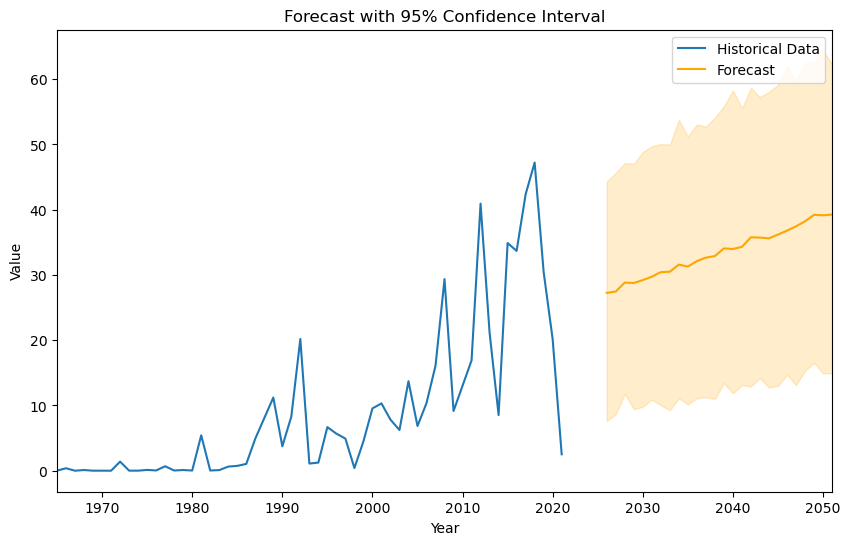

In [84]:
# Plot historical estimates and predictions
# Ensure both historical and forecasted data have the same frequency (yearly in this case)
historical_index = pd.date_range(start='1964', end='2021', freq='Y')
forecast_years = pd.date_range(start='2025', periods=26, freq='Y')

# Now ensure both DataFrames are using the same frequency
smoke_estimate_arima.index = historical_index
forecast_df.index = forecast_years

# Combine historical and forecasted data into one DataFrame
combined_data = pd.concat([
    smoke_estimate_arima['Smoke_Estimate'],  # Historical data
    forecast_df['Forecast']  # Forecast data
])

# Combine index of historical and forecast periods
combined_index = smoke_estimate_arima.index.append(forecast_df.index)

# Plot the combined data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(smoke_estimate_arima.index, smoke_estimate_arima['Smoke_Estimate'], label='Historical Data')

# Plot forecasted values
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='orange')

# Plot confidence intervals
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='orange', alpha=0.2)

# Set plot labels and title
plt.title('Forecast with 95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Value')

# Adjust x-axis limits to ensure all data is visible
plt.xlim([smoke_estimate_arima.index.min(), forecast_df.index.max()])

# Show legend
plt.legend()

# Display the plot
plt.show()

In [52]:
combined_data

1964-12-31 00:00:00     0.020477
1965-12-31 00:00:00     0.383046
1966-12-31 00:00:00     0.004412
1967-12-31 00:00:00     0.110100
1968-12-31 00:00:00     0.009459
                         ...    
2046                   35.124216
2047                   35.591686
2048                   36.059157
2049                   36.526628
2050                   36.994099
Length: 83, dtype: float64

### Visualizations
In this section we plot the following visualizations:
- histogram of fire frequency for every 50 mile bucket from Green Bay, WI for the past 60 years
- total acres burned per year for the past 60 years within 650 miles of Green Bay, WI
- AQI vs smoke estimates for the past 60 years

A more detailed explanation of each visualization can be found in the repository.

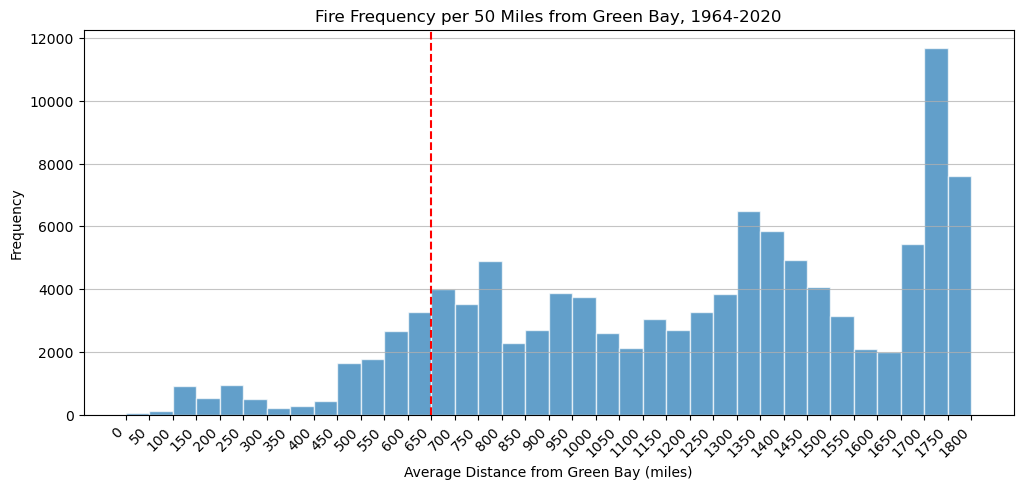

In [37]:
# fire frequency histogram
fire_data_hist = fire_data[fire_data['Average Distance to City'] <= 1800]
bins = list(range(0, 1801, 50))

plt.figure(figsize=(12, 5))

plt.hist(fire_data_hist['Average Distance to City'], bins=bins, edgecolor='white', alpha=0.7)

plt.axvline(x=650, color='red', linestyle='--', label='Smoke Estimate Cut-off')
plt.xlabel(f"Average Distance from {CITY_LOCATIONS['green_bay']['city']} (miles)")
plt.ylabel('Frequency')
plt.title(f"Fire Frequency per 50 Miles from {CITY_LOCATIONS['green_bay']['city']}, 1964-2020")
plt.xticks(bins, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)

plt.show()

<Figure size 640x480 with 0 Axes>

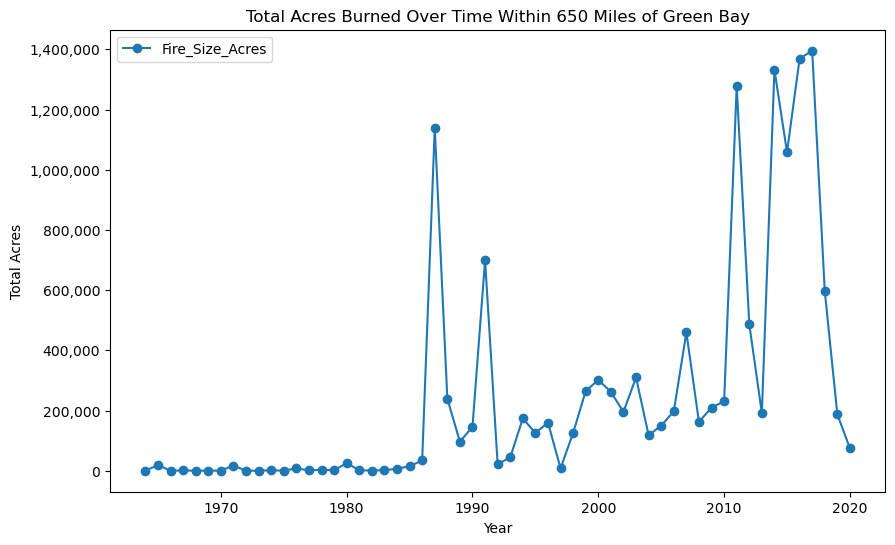

In [140]:
# time series graph of total acres burned per year for the fires occurring in the specified distance from your city.
fire_acres_by_year = fire_near_city.groupby('Fire_Year', as_index = False).agg({'Fire_Size_Acres': 'sum'})

fire_acres_by_year.plot(x='Fire_Year', y='Fire_Size_Acres', kind='line', marker='o',
                        title=f"Total Acres Burned Over Time Within 650 Miles of {CITY_LOCATIONS['green_bay']['city']}",
                       figsize=(10, 6))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Year')
plt.ylabel('Total Acres')
plt.show()

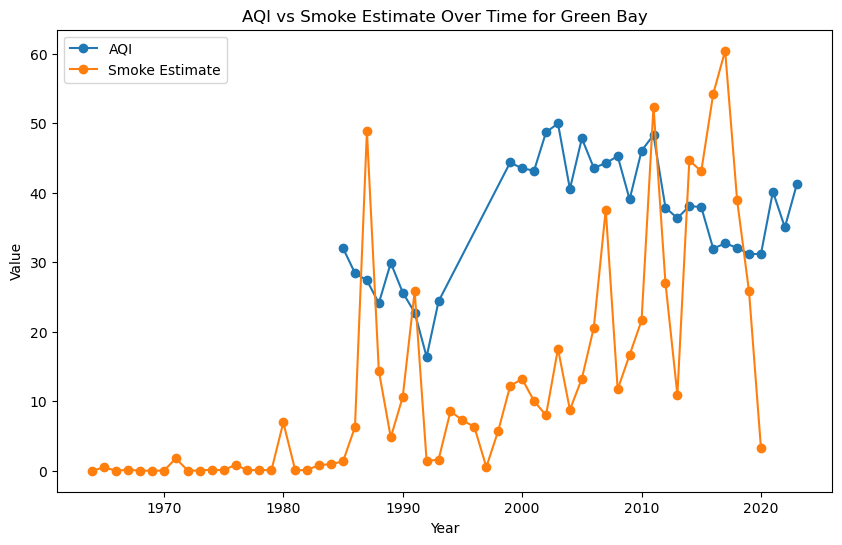

In [502]:
# AQI estimates vs smoke estimates
plt.figure(figsize=(10, 6))

ax = aqi_estimates.plot(x='year', y='aqi', kind='line', marker='o', label='AQI', ax=plt.gca())
smoke_estimate.plot(x='Fire_Year', y='Daily_Smoke_Estimate', kind='line', marker='o', label='Smoke Estimate', ax=ax)

plt.title(f"AQI vs Smoke Estimate Over Time for {CITY_LOCATIONS['green_bay']['city']}")
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()

plt.show()